In [29]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
session = "non_convex_regression"
runs = api.runs(f"tony_t_liu/{session}")

summary_list, config_list, name_list = [], [], []

meta_data = {
    "group": [],
    "id": [],
    "batch_size": [],
    "act_man_width": [],
    "weight_man_width": [],
}

stat_data = {
    "lr": [],
    "test_acc": [],
    "test_loss": [],
    "grad_norm_entire": [],
}

for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    for key in stat_data:
        if key in run.summary._json_dict:
            stat_data[key].append(run.summary._json_dict[key])
        else:
            stat_data[key].append(None)

    for key in meta_data:
        if key in run.config:
            meta_data[key].append(run.config[key])
        else:
            meta_data[key].append(None)

runs_df = pd.DataFrame(meta_data | stat_data)


In [30]:
# pad none id with empty string
runs_df


,group,id,batch_size,act_man_width,weight_man_width,lr,test_acc,test_loss,grad_norm_entire
0,mlpb32m23lr0.1stochastic,None,32,23,23,0.10,0.963333,0.110834,0.027702
1,mlpb32m23lr0.1stochastic,None,32,23,23,0.10,0.963333,0.101850,0.013831
2,mlpb32m23lr0.1stochastic,None,32,23,23,0.10,0.933333,0.159320,0.018313
3,mlpb32m23lr0.1stochastic,None,32,23,23,0.10,0.963333,0.098167,0.021400
4,mlpb32m23lr0.1stochastic,None,32,23,23,0.10,0.963333,0.107036,0.015592
...,...,...,...,...,...,...,...,...,...
2155,mlpb1m0lr0.01stochastic,None,1,0,0,0.01,0.960000,0.108509,0.039141
2156,mlpb1m0lr0.01stochastic,None,1,0,0,0.01,0.963333,0.109196,0.048761
2157,mlpb1m0lr0.01stochastic,None,1,0,0,0.01,0.970000,0.098601,0.040353
2158,mlpb1m0lr0.01stochastic,None,1,0,0,0.01,0.963333,0.097346,0.053605


In [31]:
runs_df.dropna(subset=["group"], inplace=True)
runs_df["id"] = runs_df["id"].fillna("")
runs_df["method"] = "stochastic"
runs_df.loc[runs_df["id"].str.contains("nearest"), "method"] = "nearest"
runs_df.drop(columns=["group", "id"], inplace=True)
runs_df

,batch_size,act_man_width,weight_man_width,lr,test_acc,test_loss,grad_norm_entire,method
0,32,23,23,0.10,0.963333,0.110834,0.027702,stochastic
1,32,23,23,0.10,0.963333,0.101850,0.013831,stochastic
2,32,23,23,0.10,0.933333,0.159320,0.018313,stochastic
3,32,23,23,0.10,0.963333,0.098167,0.021400,stochastic
4,32,23,23,0.10,0.963333,0.107036,0.015592,stochastic
...,...,...,...,...,...,...,...,...
2155,1,0,0,0.01,0.960000,0.108509,0.039141,stochastic
2156,1,0,0,0.01,0.963333,0.109196,0.048761,stochastic
2157,1,0,0,0.01,0.970000,0.098601,0.040353,stochastic
2158,1,0,0,0.01,0.963333,0.097346,0.053605,stochastic


In [32]:
runs_df = runs_df.groupby(["batch_size", "weight_man_width", "act_man_width", "method", "lr"]).mean().reset_index()
import numpy as np
runs_df["lr"] = runs_df["lr"].astype(np.float32)
runs_df.to_csv(f"{session}.csv")

In [33]:
runs_df

,batch_size,weight_man_width,act_man_width,method,lr,test_acc,test_loss,grad_norm_entire
0,1,0,0,stochastic,0.01,0.965417,0.108349,0.045834
1,1,0,0,stochastic,0.03,0.965417,0.104425,0.033303
2,1,0,0,stochastic,0.10,0.940000,0.139940,0.087463
3,1,1,1,stochastic,0.01,0.967500,0.105658,0.040823
4,1,1,1,stochastic,0.03,0.957500,0.113188,0.044309
...,...,...,...,...,...,...,...,...
265,32,16,16,stochastic,0.03,0.960833,0.102502,0.014019
266,32,16,16,stochastic,0.10,0.967083,0.100218,0.024860
267,32,23,23,stochastic,0.01,0.967083,0.103322,0.021977
268,32,23,23,stochastic,0.03,0.957083,0.109602,0.015331


In [37]:
runs_df["lr"].unique()

array([0.01, 0.03, 0.1 ], dtype=float32)

In [3]:
runs_df.dropna(subset=["group"], inplace=True)
runs_df["id"] = runs_df["id"].fillna("")
runs_df["method"] = "stochastic"
runs_df.loc[runs_df["id"].str.contains("nearest"), "method"] = "nearest"
runs_df.drop(columns=["group", "id"], inplace=True)
runs_df = runs_df.groupby(["batch_size", "man_width", "method", "lr"]).mean().reset_index()
import numpy as np
runs_df["lr"] = runs_df["lr"].astype(np.float32)
runs_df.to_csv(f"{session}.csv")

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def geo_mean(iterable):
    a = pd.Series(iterable)
    return a.prod()**(1.0/len(a))

def make_plot(df, dir, levels=10):
    df = df.drop(columns=["method"])
    grouped_df = df.groupby(['act_man_width', 'batch_size']).mean().reset_index()
    df_avg = grouped_df
    # Pivot the data to create a grid for the contour plot
    pivot_table = df_avg.pivot_table(index='batch_size', columns='act_man_width', values='grad_norm_entire')

    # Create a meshgrid for the contour plot
    X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)
    Z = pivot_table.values

    print(pivot_table.shape)
    print(pivot_table)

    # Pad the surrounding of Z with the same value as the edge (pad on the beginning side)
    Z = np.pad(Z, ((1, 0), (1, 0)), mode='edge')
    print(X.shape, Y.shape, Z.shape)

    # Update meshgrid to match the padded Z
    X, Y = np.meshgrid(
        np.insert(pivot_table.columns, 0, pivot_table.columns[0] - 1), 
        np.insert(pivot_table.index, 0, pivot_table.index[0] - 1)
    )

    # Create a 2D contour plot
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, Z, levels=levels)
    plt.colorbar(cp, label='Norm')

    # Set the y-axis to log scale if needed
    # plt.yscale('log')  # Uncomment this line if the y-axis should be in log scale

    # Labeling the axes
    plt.xlabel('Mantissa Width')
    plt.ylabel('Batch Size')
    lr = df['lr'].iloc[0]
    plt.savefig(f"{dir}/{lr}.png")


In [23]:
runs_df = pd.read_csv("non_convex_regression.csv")

(9, 10)
act_man_width        0         1         2         3         4         6   \
batch_size                                                                  
1              0.045834  0.040823  0.035867  0.030778  0.035195  0.030273   
2              0.045848  0.034055  0.025413  0.027652  0.024775  0.025817   
3              0.045281  0.029436  0.024573  0.025335  0.018426  0.024415   
4              0.037776  0.030410  0.023101  0.021103  0.020564  0.021729   
8              0.041176  0.029748  0.021791  0.023366  0.018533  0.021423   
12             0.040679  0.027134  0.023571  0.017485  0.021364  0.018580   
16             0.042530  0.026975  0.022136  0.019334  0.018911  0.019026   
24             0.041414  0.026949  0.025391  0.016660  0.020311  0.020994   
32             0.044923  0.025882  0.025815  0.019059  0.021373  0.021019   

act_man_width        8         12        16        23  
batch_size                                             
1              0.032368  0.03836

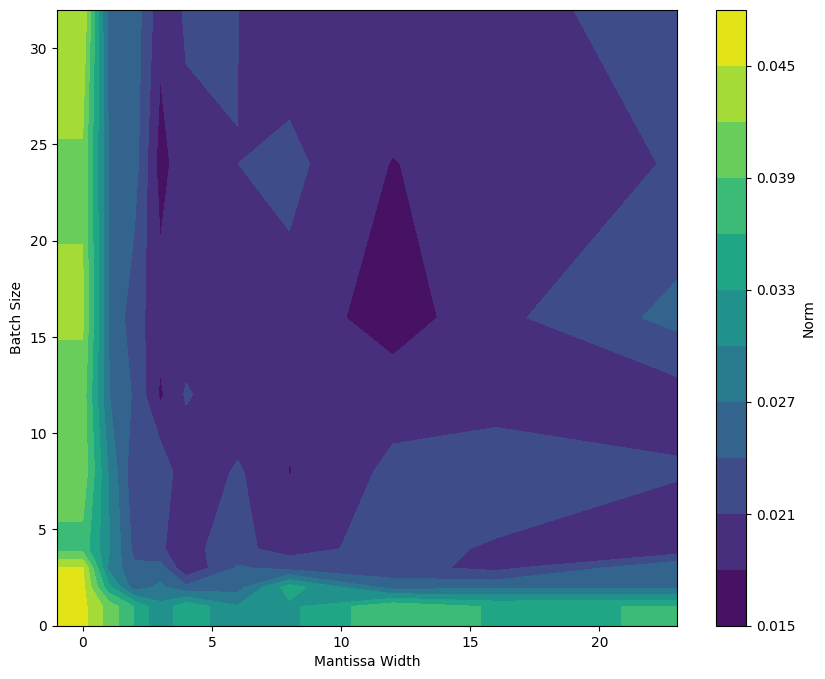

In [26]:
make_plot(runs_df[runs_df["lr"] == 0.01], "non_convex_regression")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def line_plot(df, dir):
    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.plot(df['batch_size'], df['grad_norm_entire'], marker='o', linestyle='-', color='b')

    # Adding labels and title
    plt.xlabel('Batch Size')
    plt.ylabel('Average Gradient Norm')
    plt.title('Gradient Norm vs. Batch Size for Mantissa Width 1')
    plt.grid(True)

    # Optionally, set the x-axis to log scale if the batch sizes are not uniformly distributed
    # plt.xscale('log')

    # Save the plot
    lr = df['lr'].iloc[0]  # Assuming learning rate 'lr' is constant across the DataFrame
    plt.savefig(f"{dir}/gradient_norm_vs_batch_size_{lr}.png")

    # Show the plot if you are running this in an interactive environment (optional)
    plt.show()


In [6]:
runs_df

,batch_size,man_width,method,lr,test_acc,test_loss,grad_norm_entire


In [222]:
weightlow_df = pd.read_csv("weight_quantise_only.csv")

In [223]:
bothlow_df = pd.read_csv("logistic_regression_convergence.csv")

In [224]:
actlow_df = pd.read_csv("activation_quantise_only.csv")

In [231]:
base_line["batch_size"].unique()

array([  1,   2,   3,   4,   6,   8,  12,  16,  24,  32,  50, 100, 200,
       300])

In [232]:
actlow_line = actlow_df[(actlow_df["man_width"] == 2)]

In [233]:
linebothlow = bothlow_df[(bothlow_df["lr"] == 0.03) & (bothlow_df["man_width"] == 23) & (bothlow_df["method"] == "stochastic")]

base_line = bothlow_df[(bothlow_df["lr"] == 0.03) & (bothlow_df["man_width"] == 23) & (bothlow_df["method"] == "stochastic")]

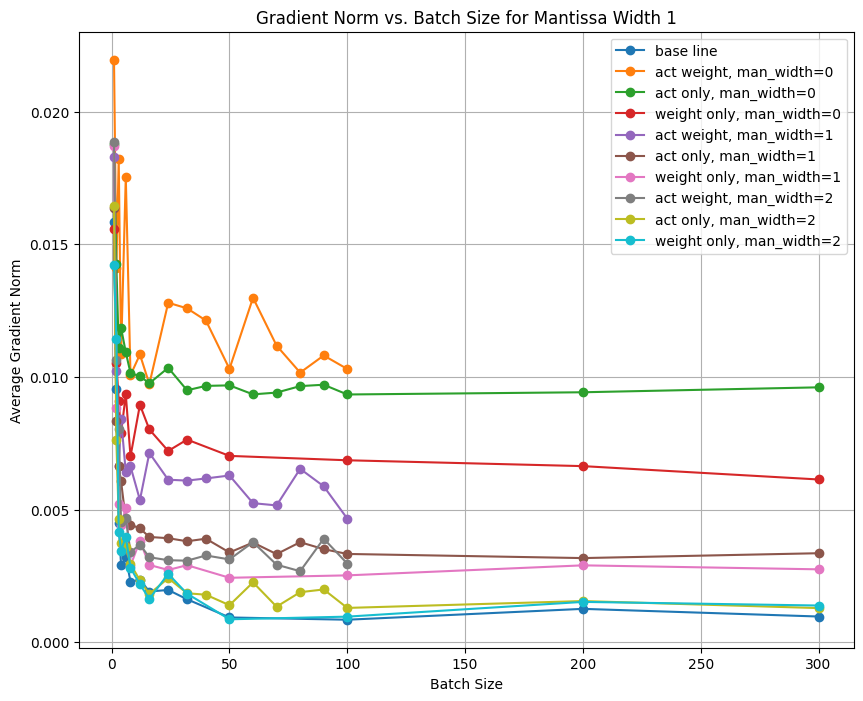

In [234]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Loop through each man_width and plot lines for both data frames
plt.plot(base_line['batch_size'], base_line['grad_norm_entire'], marker='o', linestyle='-', label='base line')
for man_width in [0, 1, 2]:
    linebothlow = bothlow_df[(bothlow_df["lr"] == 0.03) & (bothlow_df["man_width"] == man_width) & (bothlow_df["method"] == "stochastic")]
    lineactlow = actlow_df[actlow_df["man_width"] == man_width]
    lineweightlow = weightlow_df[weightlow_df["man_width"] == man_width]
    
    # Plotting and adding a label for the legend
    plt.plot(linebothlow['batch_size'], linebothlow['grad_norm_entire'], marker='o', linestyle='-', label=f'act weight, man_width={man_width}')
    plt.plot(lineactlow['batch_size'], lineactlow['grad_norm_entire'], marker='o', linestyle='-', label=f'act only, man_width={man_width}')
    plt.plot(lineweightlow['batch_size'], lineweightlow['grad_norm_entire'], marker='o', linestyle='-', label=f'weight only, man_width={man_width}')

# Adding labels and title
plt.xlabel('Batch Size')
plt.ylabel('Average Gradient Norm')
plt.title('Gradient Norm vs. Batch Size for Mantissa Width 1')
plt.grid(True)

# Adding the legend
plt.legend()

# Optionally, set the x-axis to log scale if the batch sizes are not uniformly distributed
# plt.xscale('log')

plt.show()
